In [1]:
#Все необходимое
import os
import json
import nibabel as nib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch as t
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional



import matplotlib.pyplot as plt
%matplotlib inline



import os
from PIL import Image

from sklearn.model_selection import train_test_split

import pickle as p

In [2]:
#Распаковываем картинки и предобрабатываем
path = 'C:/Users/Anton/Desktop/проектыPython/dl/lesson4/data/' 
path_images = os.path.join(path, 'images/')
path_labels = os.path.join(path, 'labels/')
with open('training_data.json', 'r') as f:
    dict_training = json.load(f)

images = []
labels = []
for entry in tqdm(dict_training):
    image = nib.load(os.path.join(path_images, entry['image']))
    label = nib.load(os.path.join(path_labels, entry['label']))
    images.append(image.get_fdata())
    labels.append(label.get_fdata())

  0%|          | 0/40 [00:00<?, ?it/s]

In [3]:
#Очень долго делал эту function, мы переводим кт снимки в нужный цветовой формат и аугментриуем их
class AugDataset(Dataset):
    def __init__(self, images, labels, split):
        self.image = np.ones((1,512,512))
        self.label = np.ones((1,512,512))

        
        for i in range(len(images)):
            for o in range(images[i].shape[-1]):
                img = images[i][...,o].astype(np.float32)
                lab = labels[i][...,o].astype(np.float32)

                img = ((img - img.min()) / (img.max() - img.min() + 1e-8) * 255).reshape(1,512,512)
                lab = (lab*255).reshape(1,512,512)

                self.image = np.vstack((self.image, img)) 
                self.label = np.vstack((self.label, lab))

        self.image = np.delete(self.image, 0, axis = 0).astype(np.uint8)
        self.label = np.delete(self.label, 0, axis = 0).astype(np.uint8)
        self.colvo = self.image.shape[0]

        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(self.image.reshape(self.colvo,1,512,512), self.label.reshape(self.colvo,1,512,512), test_size=split)
        self.train_x = t.from_numpy(self.train_x)
        self.train_y = t.from_numpy(self.train_y)
        self.test_x = t.from_numpy(self.test_x)
        self.test_y = t.from_numpy(self.test_y)

    def __len__(self):
        return len(self.train_x)
    
    def __getitem__(self, idx):
        x = Image.fromarray(self.train_x[idx][0].numpy())
        y = Image.fromarray(self.train_y[idx][0].numpy())

        if(np.random.uniform() > 0.5):
            x = functional.vflip(x)
            y = functional.vflip(y)
        if(np.random.uniform() > 0.5):
            x = functional.hflip(x)
            y = functional.hflip(y)
        if(np.random.uniform() > 0.5):
            w = np.random.choice(np.arange(1,11,2))
            h = np.random.choice(np.arange(1,11,2))
            x = functional.gaussian_blur(x,(w,h))
            y = functional.gaussian_blur(y,(w,h))
        if(np.random.uniform() > 0.5):
            ang = np.random.choice(np.arange(0,360,30)).astype(float)
            x = functional.rotate(x,ang)
            y = functional.rotate(y,ang)
        
        x = t.tensor(np.asarray(x).reshape(1,512,512), dtype=t.uint8)
        y = t.tensor(np.asarray(y).reshape(1,512,512), dtype=t.uint8)
        return x, y
    


In [572]:
#Сохраняем
dataset = AugDataset(images, labels, 0.2)
with open('dataset.pkl', 'wb') as file:
    p.dump(dataset, file)

In [4]:
with open('dataset.pkl', 'rb') as file:
    dataset = p.load(file)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

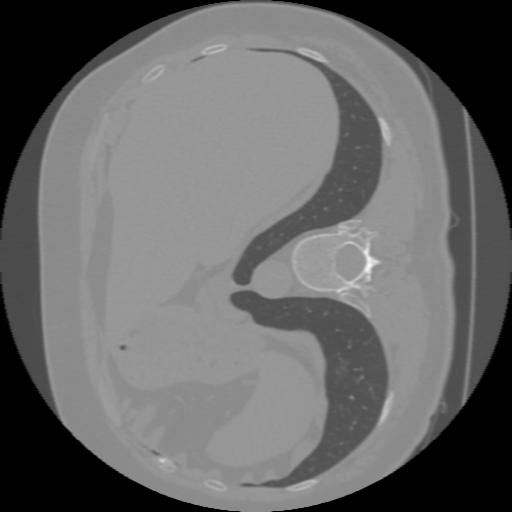

In [20]:
#Пример картинки слоя кт снимка
Image.fromarray(dataset[1000][0][0].numpy())

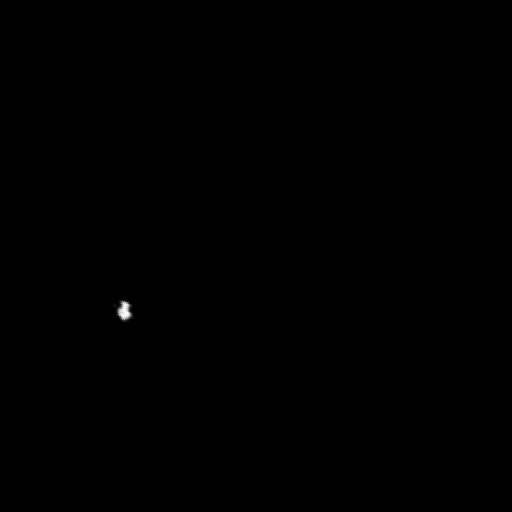

In [22]:
#И его маска с опухолью
Image.fromarray(dataset[1000][1][0].numpy())

In [4]:
#Этот лоссы взял готовые
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets, smooth=1):
        y_pred = inputs
        y_true = targets
        y_true_pos = y_true.view(-1)
        y_pred_pos = y_pred.view(-1)
        true_pos = t.sum(y_true_pos * y_pred_pos)
        false_neg = t.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = t.sum((1 - y_true_pos) * y_pred_pos)
        return 1 - (true_pos + smooth) / (true_pos + self.alpha * false_neg + (1 - self.alpha) * false_pos + smooth)

In [5]:
#Эти сам смастерил
def recall(output_batch, correct_batch, threshold=0.99):    
    output_numpy = output_batch.detach().numpy()
    correct_numpy = correct_batch.detach().numpy()
    
    amount_of_correct = np.count_nonzero(np.where(output_numpy > threshold, output_numpy, 0) + correct_numpy == 2)
    amount_all = np.count_nonzero(correct_numpy == 1)
    return amount_of_correct / amount_all


def precision(output_batch, correct_batch, threshold=0.99):   
    output_numpy = output_batch.detach().numpy()
    correct_numpy = correct_batch.detach().numpy()
    
    amount_of_correct = np.count_nonzero(np.where(output_numpy > threshold, output_numpy, 0) + correct_numpy == 2)
    amount_all = np.count_nonzero(output_numpy == 1)
    return amount_of_correct / amount_all

    
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

In [6]:
#Здесь я качаю предобученную модель unet, она очень большая
device = t.device('cuda:0')

epochs = 20
lr = 1e-4

model = t.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
    in_channels=1, out_channels=1, init_features=32, pretrained=True).to(device)
optimizer = t.optim.Adam(model.parameters(), lr=lr)
criterion = TverskyLoss(alpha=0.7)

Using cache found in C:\Users\Anton/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


RuntimeError: Error(s) in loading state_dict for UNet:
	size mismatch for encoder1.enc1conv1.weight: copying a param with shape torch.Size([32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).

In [8]:
#Тут начинаются проблемы. Одна эпоха у меня длится более 5 минут и скор после них не стабилен. Я не мог тратить так много времени 
#на одну домашку. Я так понял, что обрезать кт снимки нельзя, т.к. они обязательно должны предсказываться в формате 512*512*1
#У меня получилась сделать все, кроме обуения самой модели
history = np.array([])
gradients = np.array([])
for epoch in tqdm(range(epochs)):
    model.train()
    for x,y in loader:
        x = x.type(t.FloatTensor).to(device)
        y = y.type(t.FloatTensor).to(device)

        optimizer.zero_grad()

        loss = criterion(model(x), y/255)
        loss.backward()

        history = np.append(history,loss.item())
        #gradients = np.append(gradients,nn.utils.clip_grad_norm_(model.parameters(), 0.5).item())
        optimizer.step()
    print(history[-1])
    #print(accuracy(model, train), accuracy(model, val))
        
plt.plot(history)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

0.8611834645271301
0.9998542070388794
0.6728442907333374
0.9987798929214478
0.94482421875


KeyboardInterrupt: 

In [627]:
#Дальше уже творческий беспорядок
dat = dataset[1000][0].reshape(1,1,512,512).type(t.FloatTensor).to(device)

In [629]:
vot = model(dat)

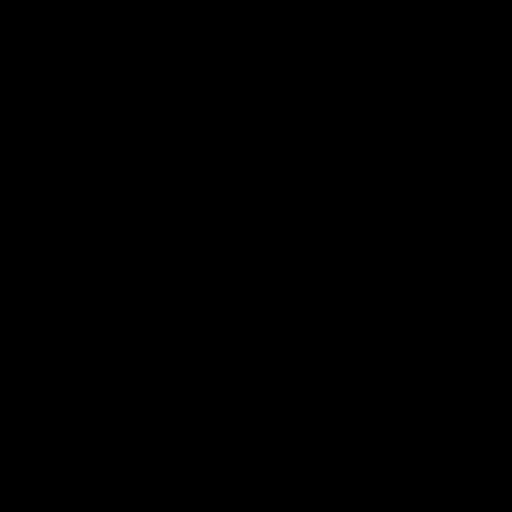

In [643]:
#Это пресказанная маска после 4 эпох - очень мало прошло времени
Image.fromarray(np.around(vot.reshape(512,512).cpu().detach().numpy()).astype(np.uint8))

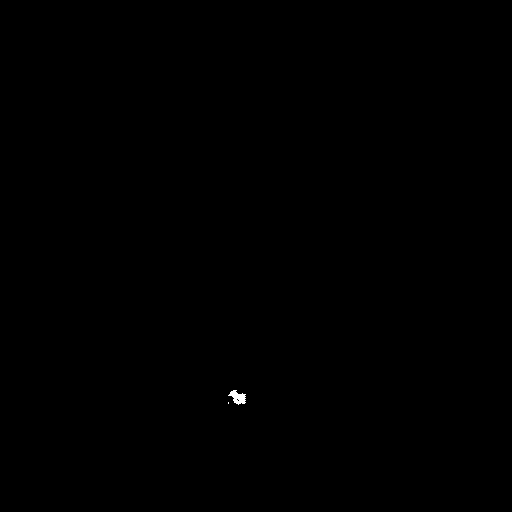

In [644]:
#Это достоверная маска
Image.fromarray(dataset[1000][1][0].numpy())